In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np

import warnings
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS, FITSFixedWarning

 [astropy.io.fits.verify]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


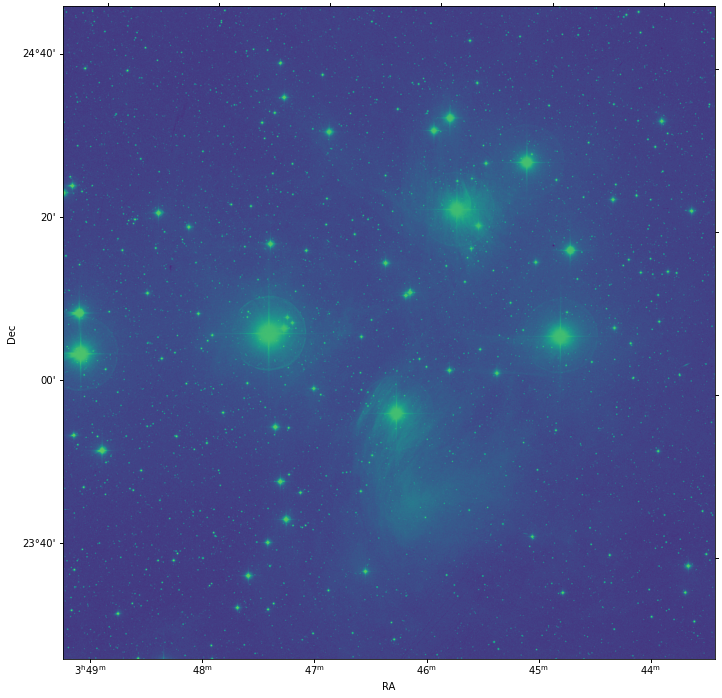

In [2]:
filename ='../data/DSS_Pleiades_large.fits'

hdu = fits.open(filename)[0]
with warnings.catch_warnings():
    # Ignore a warning on using DATE-OBS in place of MJD-OBS
    warnings.filterwarnings('ignore', message="'datfix' made the change",
                            category=FITSFixedWarning)
    wcs = WCS(hdu.header)

fig = plt.figure(figsize=(12,12))
fig.add_subplot(111, projection=wcs)
plt.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')

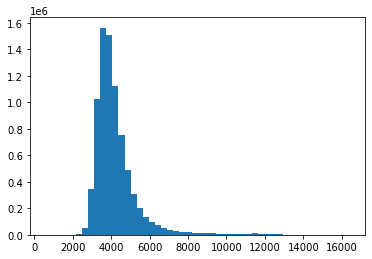

In [3]:
fix, ax = plt.subplots()
zz=ax.hist(hdu.data.flatten(), bins=50)

In [4]:
from scipy.ndimage import find_objects, label, generate_binary_structure, maximum_filter

#convd = convolve(hdu.data, np.ones((5,5))/25.0)
#img_masked = hdu.data > 22000
convd = maximum_filter(hdu.data, size=(5,5))
img_masked = convd > 13000
s = generate_binary_structure(2,2)
labeled_array, nfeatures = label(img_masked, structure=s)
print(f'Features found: {nfeatures}')
locs = find_objects(labeled_array)

Features found: 463


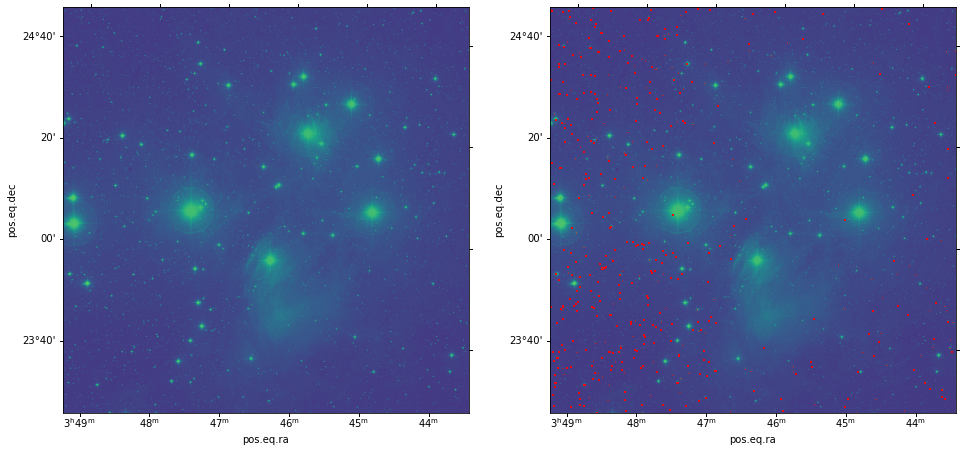

In [5]:
from  matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


rects = []
for idx in range(nfeatures):
    loc = locs[idx]
    xy = (loc[1].start, loc[0].start)
    width = loc[1].stop - loc[1].start
    height = loc[0].stop - loc[0].start
    rect = Rectangle(xy, width, height, color='red')
    rects.append(rect)

pc = PatchCollection(rects, facecolor='none', edgecolor='red')

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
ax = fig.add_subplot(122, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
ax.add_collection(pc)

In [6]:
import sys
sys.path.append('/Users/Kevin/repos/runawaysearch-1/src')
from gaiastars import gaiastars as gs
import astropy.units as u

In [7]:
import pandas as pd
df = pd.read_csv('../data/pleiades-id.csv')
pleiades_members = df.source_id.to_list()
pleiades = gs(name='Pleiades Members', description='from Columbia Paper')
pleiades.from_source_idlist(pleiades_members)

INFO: Query finished. [astroquery.utils.tap.core]


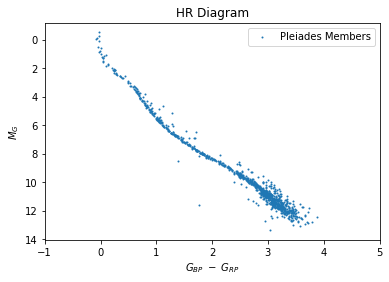

In [8]:
pleiades.plot_hrdiagram()

In [9]:
#need to clip the gaia results to fit in the image
clip_px = 20
lower_left = wcs.pixel_to_world(clip_px, clip_px)
upper_right = wcs.pixel_to_world(hdu.data.shape[1]-clip_px,hdu.data.shape[0]-clip_px)

#ra backwards since x-axis is reveresed
qry_str = f'ra > {upper_right.ra.value} and ra < {lower_left.ra.value} and dec > {lower_left.dec.value} and dec < {upper_right.dec.value}'
pleiades_clipped = pleiades.query(qry_str)
len(pleiades_clipped)

247

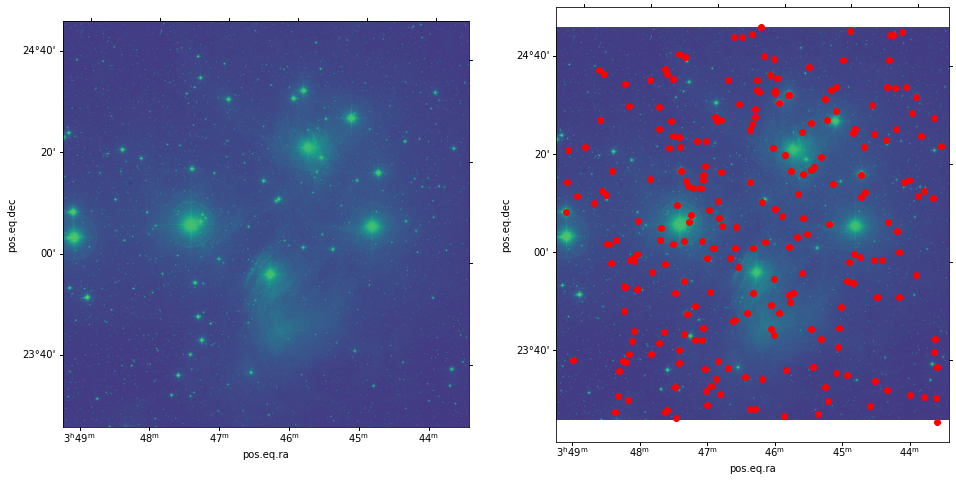

In [10]:
coords = pleiades_clipped.get_coords()
pxs = wcs.world_to_pixel(coords)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
ax = fig.add_subplot(122, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
ax.scatter(pxs[0], pxs[1], color='red')

In [11]:
alcyone = gs(name='Alcyone', description='from Gaia Object Search')
alcyone.from_source_idlist([66714384142368256])

INFO: Query finished. [astroquery.utils.tap.core]


In [12]:
from astropy.coordinates import SkyCoord
import astropy.units as u

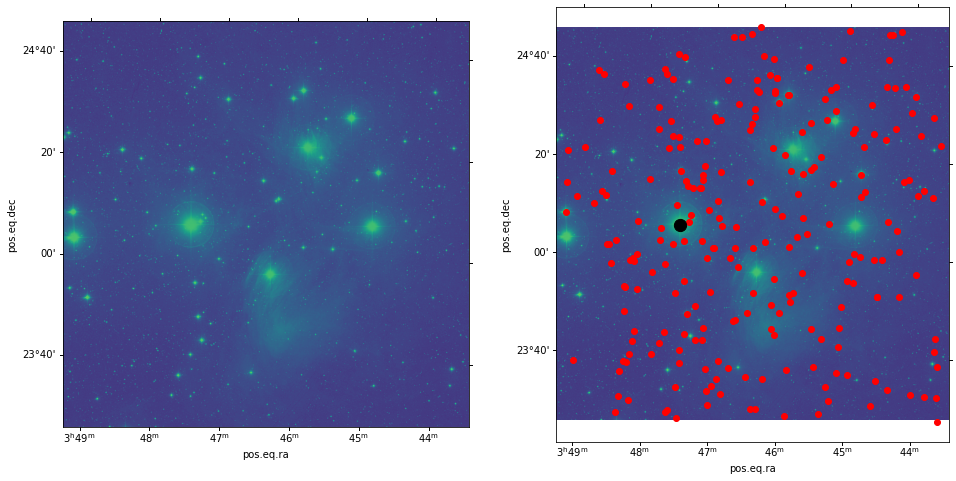

In [13]:
#alcyone_coords = alcyone.get_coords()
alcyone_coords = SkyCoord(alcyone.objs.iloc[0].ra*u.deg, alcyone.objs.iloc[0].dec*u.deg)
alcyone_pxs = wcs.world_to_pixel(alcyone_coords)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
ax = fig.add_subplot(122, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
ax.scatter(pxs[0], pxs[1], color='red')
ax.scatter(alcyone_pxs[0], alcyone_pxs[1], color='black', s=150)

In [50]:
pleiades_biggies_ids = {'Atlas':66526127137440128,
                        'Pleione': 66529975427235712,
                        'Alcyone':66714384142368256,
                        'Merope':65205373152172032,
                        'Electra': 65271996684817280,
                        'Maia':65283232316451328,
                        'Taygeta': 65296907494549120,
                        'Asterope':66798496781121792,
                        'Celaeno':65287458566524928}
idl = [id for id in pleiades_biggies_ids.values()]

pleiades_biggies = gs(name='Big Stars in Pleiades', description='From Wikipedia')
pleiades_biggies.from_source_idlist(idl)

#stuff in missing parallax for Alcyone (source Simbad)
pleiades_biggies.objs.at[66714384142368256,'parallax'] = 8.09
pleiades_biggies.objs.at[66714384142368256,'r_est'] = 1000/8.09

#fix up the names
id_to_name = dict((v,k) for k,v in pleiades_biggies_ids.items())


cols, mags = pleiades_biggies.get_colors()
pleiades_biggies.objs.reset_index(inplace=True)
pleiades_biggies.objs['typed_id']=[id_to_name[t_id] for t_id in pleiades_biggies.objs.typed_id]
pleiades_biggies.objs.set_index('typed_id', inplace=True)

INFO: Query finished. [astroquery.utils.tap.core]


In [52]:
pleiades_biggies.objs

,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe,r_est
typed_id,,,,,,,,,,,,
Atlas,66526127137440128,57.290689,24.053212,8.118448,19.078968,-46.193245,NaN,3.615795,3.583036,3.619412,4.116527,123.176246
Pleione,66529975427235712,57.296831,24.136498,7.241378,19.496054,-47.649899,NaN,5.203287,5.185276,5.218389,1.303494,138.095257
Alcyone,66714384142368256,56.871251,24.104934,8.090000,NaN,NaN,NaN,2.896132,3.026533,2.878190,NaN,123.609394
Merope,65205373152172032,56.581671,23.948144,7.067029,13.075220,-48.403790,NaN,4.172742,4.148266,4.159457,2.329801,141.502185
Electra,65271996684817280,56.219005,24.113133,8.345685,20.541505,-46.081450,4.795939,3.698209,3.645838,3.733800,2.767541,119.822397
Maia,65283232316451328,56.456796,24.367541,7.671310,19.515752,-45.527310,16.286316,3.863349,3.836872,3.850640,3.542117,130.355833
Taygeta,65296907494549120,56.302163,24.467064,9.544445,16.291673,-47.206094,NaN,4.261022,4.224305,4.331630,2.314559,104.772985
Asterope,66798496781121792,56.477085,24.554305,7.305275,20.331403,-46.022055,11.792832,5.752026,5.729278,5.752268,0.879898,136.887379
Celaeno,65287458566524928,56.200992,24.289268,7.385247,19.849144,-44.965596,16.494202,5.441325,5.419782,5.441004,0.963313,135.405087


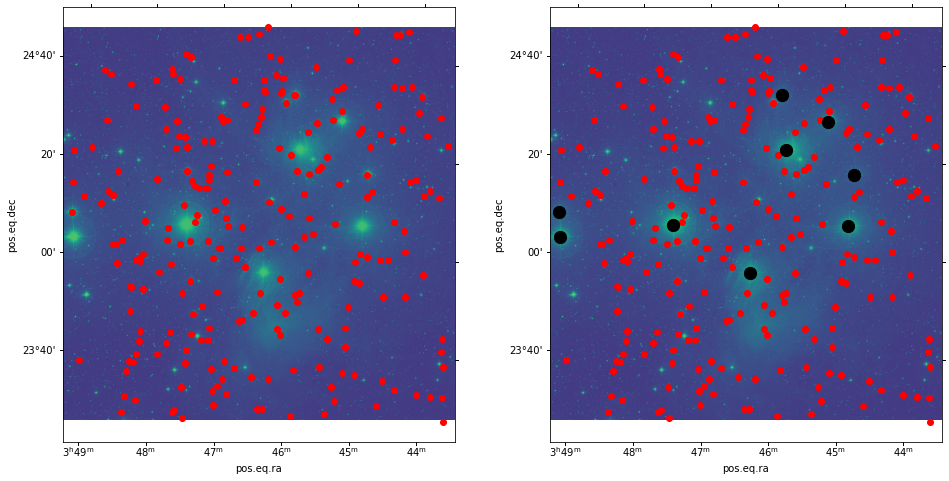

In [53]:
biggies_coords = pleiades_biggies.get_coords()
biggies_pxs = wcs.world_to_pixel(biggies_coords)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
ax.scatter(pxs[0], pxs[1], color='red')
ax = fig.add_subplot(122, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
ax.scatter(pxs[0], pxs[1], color='red')
#ax.scatter(alcyone_pxs[0], alcyone_pxs[1], color='black', s=150)
ax.scatter(biggies_pxs[0], biggies_pxs[1], color='black', s=150)

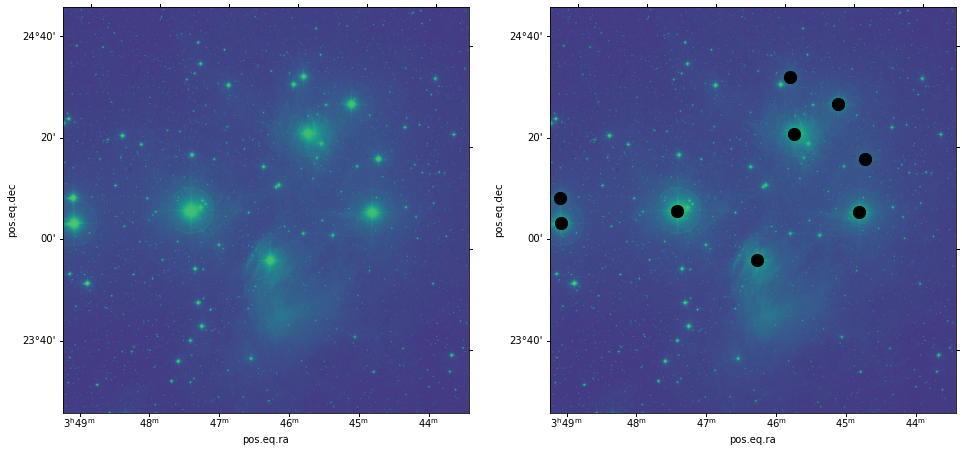

In [54]:
biggies_coords = pleiades_biggies.query(qry_str).get_coords()
biggies_pxs = wcs.world_to_pixel(biggies_coords)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
#ax.scatter(pxs[0], pxs[1], color='red')
ax = fig.add_subplot(122, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
#ax.scatter(pxs[0], pxs[1], color='red')
#ax.scatter(alcyone_pxs[0], alcyone_pxs[1], color='black', s=150)
ax.scatter(biggies_pxs[0], biggies_pxs[1], color='black', s=150)

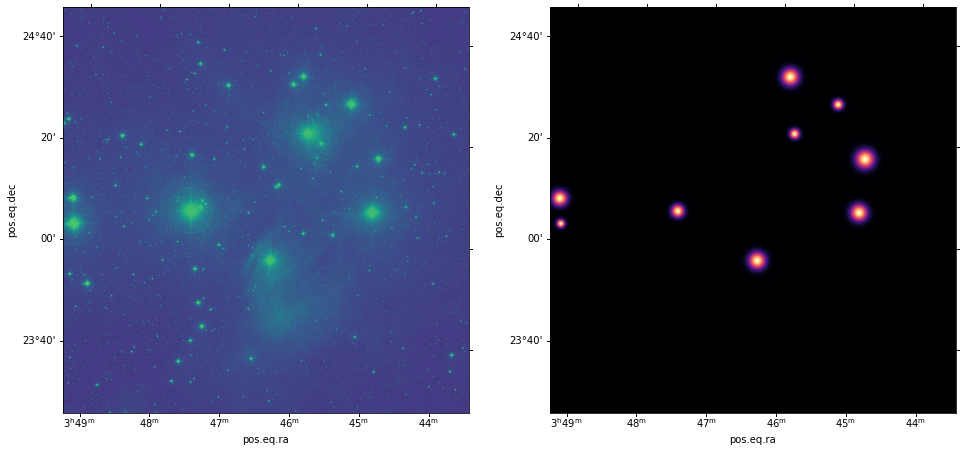

In [68]:
from scipy.stats import multivariate_normal

np.random.seed(1234)

s = hdu.data.shape
x = np.linspace(-10, 10, s[1], endpoint=True)
y = np.linspace(-10, 10, s[0], endpoint=True)
img = np.zeros(s, dtype=float)
X,Y = np.meshgrid(x,y)
pos = np.dstack((X,Y))
scale_factor=np.random.uniform(0,1, size=len(biggies_pxs[0]))
for sf, p_x, p_y in zip(scale_factor, biggies_pxs[0], biggies_pxs[1]):
    if np.isnan(p_x): continue
    mean_x = x[int(p_x)]
    mean_y = y[int(p_y)]
    rv = multivariate_normal([mean_x, mean_y], 0.1*sf*np.eye(2))
    img += sf*np.clip(rv.pdf(pos),0.0, None)


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
#ax.scatter(biggies_pxs[0], biggies_pxs[1], color='black', s=150)
#ax.scatter(pxs[0 pxs[1], color='red')
ax = fig.add_subplot(122, projection=wcs)
ax.imshow(img, origin='lower', cmap=plt.cm.magma)
#ax.scatter(pxs[0], pxs[1], color='white', s=1)

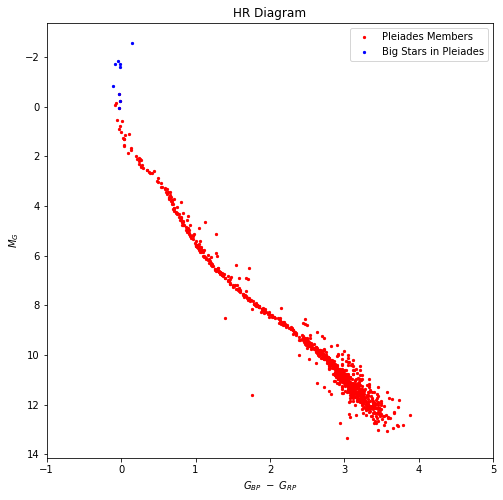

In [66]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
pleiades.plot_hrdiagram(ax=ax, color='red', s=5)
pleiades_biggies.plot_hrdiagram(ax=ax, color='blue', s=5)
ax.legend()


In [160]:
def plot_star(gstar, wcs, XX, YY, mag0rad=5):

    # color determines color on the color scale
    bp_rp = np.power(100, (20 - (gstar.phot_bp_mean_mag - gstar.phot_rp_mean_mag))/5)
    # apparent mag determines spread (analogous to FWHM)
    app_mag = ((25 - gstar.phot_g_mean_mag)/5) * np.log(100)
    #rad = np.sqrt(app_mag)*mag0rad
    rad = np.power(app_mag, 2)*mag0rad

    # pixel on which to center star
    coord = SkyCoord(gstar.ra, gstar.dec, unit=u.deg)
    pix = wcs.world_to_pixel(coord)

    #compute squared pixel distance from star center
    dist2 = (XX-pix[0])**2 + (YY-pix[1])**2
    #zero it out beyond radius det'd by app_mag
    dist2 = np.where(dist2>(rad**2),  0., 1.0)

    #set the temperature and return

    return dist2*bp_rp

In [161]:
s = hdu.data.shape
# x = np.linspace(-10, 10, s[1], endpoint=True)
# y = np.linspace(-10, 10, s[0], endpoint=True)
x = np.arange(s[1])
y = np.arange(s[0])

X,Y = np.meshgrid(x,y)

img = np.zeros(X.shape, dtype=float)

for i in range(len(pleiades_biggies)-1):
    np.maximum(img, plot_star(pleiades_biggies.objs.iloc[i], wcs, X, Y, mag0rad=0.1), out=img)
for i in range(len(pleiades_clipped)):
    np.maximum(img, plot_star(pleiades_clipped.objs.iloc[i], wcs, X, Y, mag0rad=0.1), out=img)



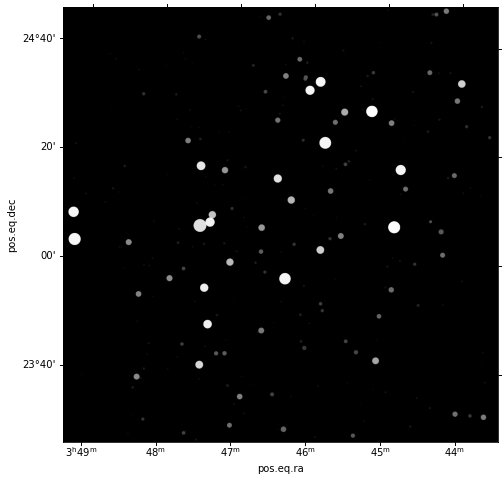

In [163]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(img, plt.cm.Greys_r)


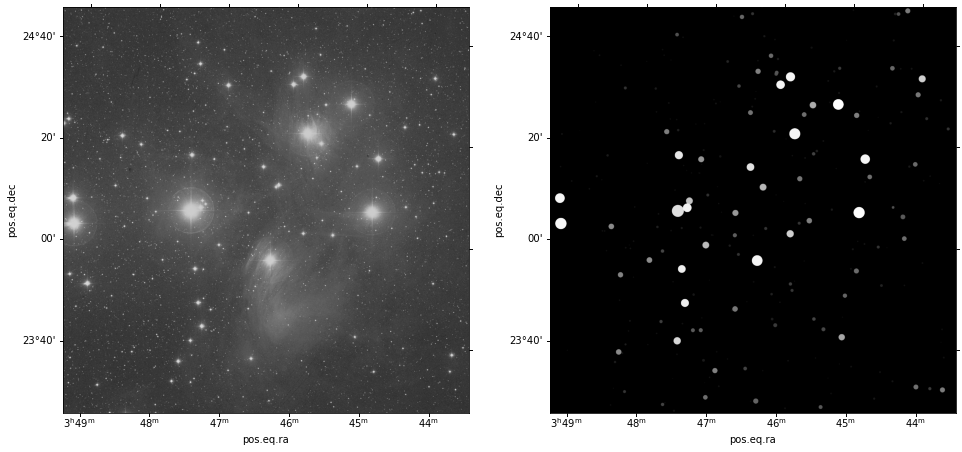

In [164]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.Greys_r)

ax = fig.add_subplot(122, projection=wcs)
ax.imshow(img, origin='lower', cmap=plt.cm.Greys_r)


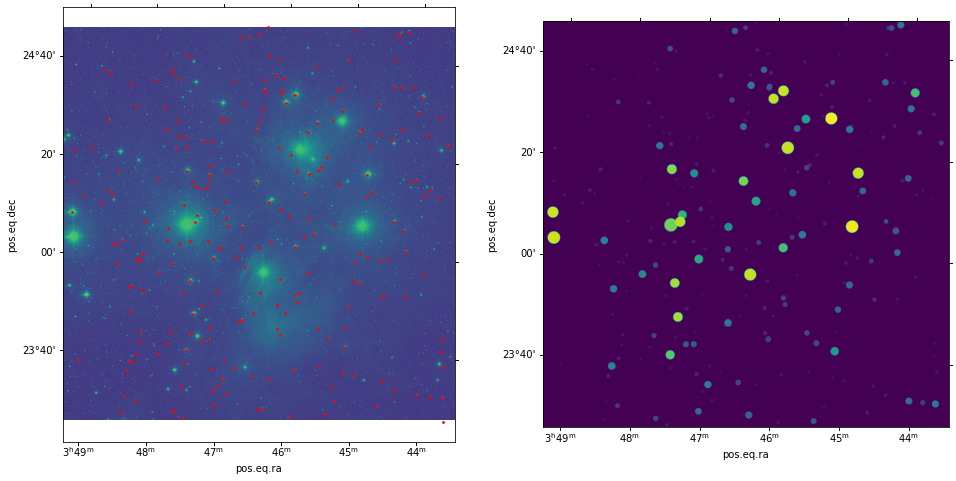

In [153]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
ax.scatter(pxs[0], pxs[1], color='red',s=3)

ax = fig.add_subplot(122, projection=wcs)
ax.imshow(img, origin='lower', cmap=plt.cm.viridis)

In [140]:
(((25 - pleiades_clipped.objs.phot_g_mean_mag)/5) * np.log(100))

typed_id
69806039039416832     6.795105
69807963184755840     7.803917
69811364798863744     9.704343
68294554148575232    10.465752
68295481861500928    10.345664
                       ...    
65297251091930624     7.810807
65297594689312768     8.597952
65298208867376384     6.658431
65298483745290368     7.655804
65299965511216384     8.600677
Name: phot_g_mean_mag, Length: 247, dtype: float32